In [3]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [4]:
house = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/solar_home_system_data_log-master/data/House_2_January_TimeSeries.csv')
house2 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/solar_home_system_data_log-master/data/House_3_January_TimeSeries.csv')
house3 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/solar_home_system_data_log-master/data/House_4_January_TimeSeries.csv')

house2.head(5)



,Time,#0: CH0 [Â°C],#1: CH1 [V],#2: CH2 [Digit],#3: CH3 [V],#4: CH4 [Digit],PV Current,Battery Current
0,6/23/15 12:28,30.40,18.37,32777,12.89,32779,-0.114042,-0.09240
1,6/23/15 12:29,30.42,18.95,32776,12.88,32779,-0.095035,-0.09240
2,6/23/15 12:30,30.43,18.79,32774,12.88,32777,-0.057021,-0.05544
3,6/23/15 12:31,30.43,13.30,32760,12.80,32750,0.209077,0.44352
4,6/23/15 12:32,30.42,13.23,32766,12.75,32745,0.095035,0.53592


In [5]:

columns = ['Time', 'Temperature', 'PV_V', 'Digit', 'Battery_V', 'Digit2', 'PV_Current', 'Battery_Current']
house.columns = columns
house2.columns = columns
house3.columns = columns

house2.head(5)

,Time,Temperature,PV_V,Digit,Battery_V,Digit2,PV_Current,Battery_Current
0,6/23/15 12:28,30.40,18.37,32777,12.89,32779,-0.114042,-0.09240
1,6/23/15 12:29,30.42,18.95,32776,12.88,32779,-0.095035,-0.09240
2,6/23/15 12:30,30.43,18.79,32774,12.88,32777,-0.057021,-0.05544
3,6/23/15 12:31,30.43,13.30,32760,12.80,32750,0.209077,0.44352
4,6/23/15 12:32,30.42,13.23,32766,12.75,32745,0.095035,0.53592


In [6]:
# define assumptions and calibration values

# calibration slope for 3 amps
slope_channel_2 = [ -0.0190226, -0.0181098, -0.018034, -0.0184049, 0.0185455]
slope_channel_4 = [ 0.017730, -0.01779, -0.01845, -0.018519, 0.018765]

zero_channel_2 = [32766, 32786, 32776, 32771, 32774]
zero_channel_4 = [32775, 32785, 32777, 32771, 32775]

# assumptions 
pv_eff = 0.15 # efficiency
pv_power = 70 # watts, TPS panel
pv_area = 0.467 # area of panel m2
cc_eff = 0.95 # charge controller efficiency

# Separate Spillage from Load 
# Only day-time appliance 
fan_spillage = 14 # %mean power consumption of fan, Watts 
sigma_fan_spillage = .1*fan_spillage # assumption on standard deviation of fan power
ci_90 = 1.645
ci_95 = 1.96 

# 90% confidence interval
fan_90_ci_lower = fan_spillage-ci_90*sigma_fan_spillage 
fan_90_ci_upper = fan_spillage + ci_90*sigma_fan_spillage
# define functions 

def calibration(data, number):
    
    house_number = number
    
    data['PV_Current_Adj'] = (data['PV_Current'] - zero_channel_2[house_number])*slope_channel_2[house_number]
    data['Battery_Current_Adj'] = (data['Battery_Current'] - zero_channel_4[house_number])*slope_channel_4[house_number]

    # Set negative PV current values to 0 

    data['PV_Current_Adj'] = np.where(data['PV_Current_Adj'] < 0, 0, data['PV_Current_Adj'])
    
    # Calculate load values 

    data['PV_Power'] = data['PV_V'] * data['PV_Current']
    data['Battery_Power'] = data['Battery_V'] * data['Battery_Current']
    data['Load'] = data['PV_Power'] + data['Battery_Power']

    # Set negative load values to 0 
    data['Load_Corrected'] = np.where(data['Load'] < 0, 0, data['Load'])
    
    # Calculate Rough Proxy for Irradiance
    #solar.irradiance_datalog(k) = (pv.power(k)./(solar.pv_eff*solar.pv_area))*(1/solar.cc_eff);
    data['Solar_Irradiance'] = (data['PV_Power'] / (pv_eff * pv_area)) * (1/cc_eff)

# if solar irrdiance is above 5 W/m2 and load value is NOT in 90% CI range, classify as spillage

    data['Spillage'] = np.where((data['Solar_Irradiance'] > 0.05) & (data['Load_Corrected'] < fan_90_ci_lower) | (data['Load_Corrected'] > fan_90_ci_upper), data['Load_Corrected'], 0)
    data['Spillage'] = np.where(data['Load_Corrected'] < fan_90_ci_lower, data['Load_Corrected'], 0)
            
    data['Time'] = pd.to_datetime(data['Time'])
    data_time = data.set_index(data['Time'])
    data_time.drop('Time', inplace=True, axis=1)
    
    plt.figure(figsize=(16,8))
    data_time.loc[:,['Load_Corrected', 'Spillage']].plot(kind='line')
    plt.show()
    
    return data



<Figure size 1152x576 with 0 Axes>

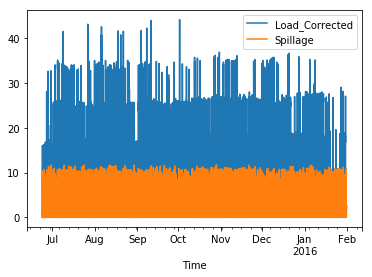

<Figure size 1152x576 with 0 Axes>

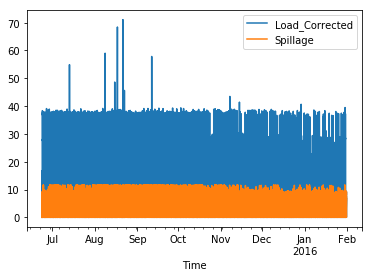

<Figure size 1152x576 with 0 Axes>

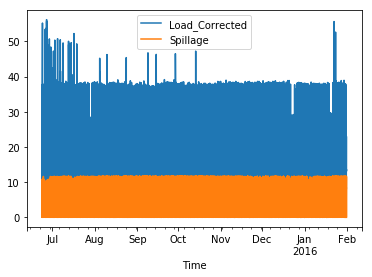

In [8]:
house_cp, house2_cp, house3_cp = house.copy(), house2.copy(), house3.copy()

house_processed = calibration(house_cp, 2)
house2_processed = calibration(house2_cp, 3)
house3_processed = calibration(house3_cp, 4)

In [9]:
house_processed.to_csv('House_2_Processed1_TimeSeries.csv')
house2_processed.to_csv('House_3_Processed1_TimeSeries.csv')
house3_processed.to_csv('House_4_Processed1_TimeSeries.csv')